# Nova Reel Movie Studio

### Exploratory Data Analysis (EDA)

This is a crucial initial step in data analysis. 
EDA involves **investigating and summarizing the main characteristics of our dataset**. 

**Core Goals of EDA:**

1. Understand the Data
2. Identify Patterns and Trends
3. Detect Anomalies and Outliers
4. Assess Data Quality
5. Communicate Insights

### Data Understanding

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import os

%matplotlib inline

### Fetch the required data

To extract the im.db.zip file using Python, you can use the zipfile module. This will extract the contents of im.db.zip into the extractedData directory.

In [2]:
# Define the path to the zip file and the extraction directory
zip_file_path = './zippedData/im.db.zip'
extraction_dir = './extractedData/'

# Check if the file exists
if os.path.exists(zip_file_path):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print("Extraction complete.")
else:
    print(f"File {zip_file_path} does not exist.")

Extraction complete.


This code connects to a SQLite database (im.db), creates a cursor, and then uses pandas to execute a query that gets and stores the names of all tables within that database.

In [2]:
conn = sqlite3.connect('./extractedData/im.db')
cursor = conn.cursor()

# Display table names
table_names = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
table_names

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


We read all data from the movie_basics table in the connected SQLite database into a pandas DataFrame named movie_basics_df, and then we display a summary of this DataFrame's structure and contents.

In [3]:
movie_basics_df = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [4]:
movie_ratings_df = pd.read_sql("SELECT * FROM movie_ratings;", conn)
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
# Close the connection
conn.close()

### Data Preparation

Data preparation and cleaning is the crucial process of getting your raw, messy data into a usable and reliable format for analysis. It involves a series of steps to identify and correct errors, inconsistencies, and missing values, as well as transforming and structuring the data to make it suitable for your specific analytical goals.

#### Data Cleaning

In [6]:
# Standardize text columns (strip spaces and convert to lowercase)
for col in movie_basics_df.select_dtypes(include=['object']).columns:
    movie_basics_df[col] = movie_basics_df[col].str.strip().str.lower()

# Display the updated DataFrame
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,sunghursh,sunghursh,2013,175.0,"action,crime,drama"
1,tt0066787,one day before the rainy season,ashad ka ek din,2019,114.0,"biography,drama"
2,tt0069049,the other side of the wind,the other side of the wind,2018,122.0,drama
3,tt0069204,sabse bada sukh,sabse bada sukh,2018,NaN,"comedy,drama"
4,tt0100275,the wandering soap opera,la telenovela errante,2017,80.0,"comedy,drama,fantasy"


In [7]:
# Check for missing values
movie_basics_df.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [8]:
# Remove rows with missing values in 'original_title', 'runtime_minutes' or 'genres'
movie_basics_df = movie_basics_df.dropna(subset=['original_title', 'runtime_minutes', 'genres'])

# Display the updated DataFrame
print(movie_basics_df.shape)

(112232, 6)


This code refines the movie_basics_df DataFrame in two key ways:

1. It removes duplicate movie entries. 
    - It looks for rows that have the same value in both the 'primary_title' (the main title of the movie) and the 'start_year' (the year the movie was released). 
    - If it finds such duplicates, it keeps only the very first occurrence of that movie and year combination and discards any subsequent identical entries. 
    - This ensures that each unique movie release is represented only once in the dataset.

2. it standardizes the 'runtime_minutes' column.
    - It converts the data type of the values in this column to integers. 
    - By converting it to an integer type, the code ensures that the runtime is represented as whole numbers of minutes, which is the most logical and useful format for analysis, such as calculating averages or comparing durations.

In [9]:
# Drop duplicates based on 'primary_title' and 'start_year'
movie_basics_df = movie_basics_df.drop_duplicates(subset=['primary_title', 'start_year'], keep='first')

# Convert 'runtime_minutes' to integer
movie_basics_df['runtime_minutes'] = movie_basics_df['runtime_minutes'].astype(int)

# Display the updated DataFrame
print(f"Shape after dropping duplicates: {movie_basics_df.shape}")

Shape after dropping duplicates: (110927, 6)


#### Calculate the runtime_minutes threshold

* This calculates the average movie runtime and then removes movies with runtimes below this average.
* The **ONLY RUN ONCE** comment is a crucial reminder to avoid unintended repeated filtering.
* We remove rows that have runtime_minutes below 86.29 minutes

In [10]:
# Calculate the threshold (e.g., mean runtime)

runtime_threshold = movie_basics_df['runtime_minutes'].mean()

# Remove rows where 'runtime_minutes' is below the threshold
# ONLY RUN ONCE
# Uncomment the following line to remove rows with runtime_minutes below the threshold

movie_basics_df = movie_basics_df[movie_basics_df['runtime_minutes'] >= runtime_threshold]

# Display the updated DataFrame
print(f"Shape after removing rows with runtime_minutes below {runtime_threshold}: {movie_basics_df.shape}")

Shape after removing rows with runtime_minutes below 86.2930936561883: (56056, 6)


We focuse on identifying and displaying duplicate movie entries based on their primary title and genres.

* First, we find all rows that have the same 'primary_title' and 'genres'. The keep=False argument ensures that all occurrences of the duplicates are flagged. These duplicate rows are stored in a new DataFrame called duplicated_movie_basics.

* Next, we sort these identified duplicate entries alphabetically by 'primary_title' and then chronologically by 'start_year'. This makes it easier to visually inspect the duplicated movies.

* This code helps us find and examine movies that share the same title and genre, allowing us to understand potential data inconsistencies or multiple entries for the same movie.

In [11]:
# Check for duplicates in the 'primary_title' and 'genres' column
duplicated_movie_basics = movie_basics_df[movie_basics_df.duplicated(subset=['primary_title', 'genres'], keep=False)]
# sort in descending order by 'primary_title' and 'start_year'
duplicated_movie_basics = duplicated_movie_basics.sort_values(by=['primary_title', 'start_year'], ascending=[True, True])
# Display the number of duplicate rows and the duplicates
print(f"Number of duplicate primary titles: {duplicated_movie_basics.shape[0]}")
duplicated_movie_basics.tail()
print("Shape of movie_basics_df:", movie_basics_df.shape)

Number of duplicate primary titles: 488
Shape of movie_basics_df: (56056, 6)


In [12]:
# Drop rows in movie_basics_df that match primary_title and genres in duplicated_movie_basics
movie_basics_df = movie_basics_df[~movie_basics_df.set_index(['primary_title', 'genres']).index.isin(
    duplicated_movie_basics.set_index(['primary_title', 'genres']).index
)]

# Display the updated DataFrame
print(f"Shape after dropping duplicates: {movie_basics_df.shape}")

Shape after dropping duplicates: (55568, 6)


This code snippet aims to **refine the `movie_basics_df` to keep only one entry for movies that are listed with multiple unique genres, and remove all other movie entries.**

1.  It **identifies movie titles that have more than one unique genre** associated with them.
2.  It then **selects the first occurrence of each of these multi-genre movies**.
3.  A new DataFrame `df_final` is created containing only these first instances of multi-genre movies.
4.  Finally, it **removes all rows from the original `movie_basics_df` that are also present in `df_final` based on both 'primary\_title' and 'genres'**.

In [13]:
# Step 1: Find titles with multiple unique genres
genre_counts_new = movie_basics_df.groupby('primary_title')['genres'].nunique()


# Step 2: Identify titles with more than one genre
titles_with_multiple_genres_new = genre_counts_new[genre_counts_new > 1].index

# Step 3: Keep only the first instance of such titles
basics_duplicates = movie_basics_df[movie_basics_df['primary_title'].isin(titles_with_multiple_genres_new)]
basics_first_instances = basics_duplicates.drop_duplicates(subset='primary_title', keep='first')

# Step 4: Remove all other titles (that do not have multiple genres)
df_final = basics_first_instances.copy()

# Remove rows in df_final from movie_basics_df
movie_basics_df = movie_basics_df[~movie_basics_df.set_index(['primary_title', 'genres']).index.isin(
    df_final.set_index(['primary_title', 'genres']).index
)]

# Display the updated DataFrame
print(f"Shape after removing rows in df_final: {movie_basics_df.shape}")

Shape after removing rows in df_final: (54064, 6)


This snippet deals with **duplicate movie titles** in the `movie_basics_df`.

First, it **identifies all rows where the 'primary\_title' is duplicated**, keeping all occurrences of the duplicated titles.

The number of duplicate primary titles is 532.

Then, for these identified duplicate titles, it **modifies the 'primary\_title' by appending the 'start\_year' in parentheses**. This creates a more unique identifier for movies with the same title but different release years.

It resolves duplicate movie titles by making them unique through the addition of their release year.

In [14]:
# Identify duplicate primary_title values
duplicated_basics_title = movie_basics_df[movie_basics_df.duplicated(subset=['primary_title'], keep=False)]

# Append start_year to primary_title for duplicates
movie_basics_df.loc[duplicated_basics_title.index, 'primary_title'] = (
    movie_basics_df.loc[duplicated_basics_title.index, 'primary_title'] + 
    " (" + movie_basics_df.loc[duplicated_basics_title.index, 'start_year'].astype(str) + ")"
)

# Display the updated DataFrame
print(f"Shape after updating duplicate primary_title: {movie_basics_df.shape}")

Shape after updating duplicate primary_title: (54064, 6)


In [15]:
# Identify duplicate primary_title values
v = movie_basics_df[movie_basics_df.duplicated(subset=['primary_title'], keep=False)]

# Display the duplicates
print(f"Number of duplicate primary titles: {v.shape[0]}")

Number of duplicate primary titles: 0


In [16]:
# This is the final DataFrame after all the cleaning steps
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54064 entries, 0 to 146139
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movie_id         54064 non-null  object
 1   primary_title    54064 non-null  object
 2   original_title   54064 non-null  object
 3   start_year       54064 non-null  int64 
 4   runtime_minutes  54064 non-null  int32 
 5   genres           54064 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 5.2+ MB


In [17]:
# Save the cleaned DataFrame to a CSV file
# Create 'cleaned_data' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save movie_basics_df to a CSV file
movie_basics_df.to_csv(f'{output_folder}/movie_basics.csv', index=False)

print("DataFrames have been successfully saved to the 'extracted' folder.")

DataFrames have been successfully saved to the 'extracted' folder.


In summary, the cleaning process for `movie_basics_df` involved several key steps to ensure data quality and consistency for further analysis:

* **Duplicate Removal:** We eliminated exact duplicate movie entries based on their primary title and release year, retaining only the first occurrence.
* **Runtime Conversion:** The 'runtime\_minutes' column was converted to an integer data type for proper numerical handling.
* **Runtime Filtering:** We explored filtering out movies with runtimes below the average, although this step might have been conditionally applied.
* **Handling Multi-Genre Movies:** We addressed movies listed with multiple unique genres, potentially keeping only the first instance of such titles while removing others.
* **Resolving Duplicate Titles:** For movies with the same primary title, we made them unique by appending their release year to the title.

These steps collectively aimed to create a more reliable and standardized `movie_basics_df` by removing redundancies, ensuring correct data types, and addressing potential ambiguities in movie titles and genre information. The resulting DataFrame is now better prepared for subsequent merging with other datasets and for meaningful analysis.

## Movie Ratings

### Introduction to Movie Ratings

The **movie ratings** dataset provides valuable insights into audience preferences and perceptions of movies. It includes key metrics such as:

1. **Average Ratings (`averagerating`)**: Represents the mean rating given by users, reflecting the overall quality or popularity of a movie.
2. **Number of Votes (`numvotes`)**: Indicates the total number of user ratings, serving as a measure of a movie's reach or engagement.

This dataset is crucial for understanding audience behavior, identifying top-rated movies, and analyzing trends in movie ratings. It can be used to filter and focus on highly-rated or widely-voted movies for further analysis.

In [18]:
# Read the cleaned DataFrame from the CSV file to verify
cleaned_movie_basics_df = pd.read_csv("./cleaned_data/movie_basics.csv")
cleaned_movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54064 entries, 0 to 54063
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movie_id         54064 non-null  object
 1   primary_title    54064 non-null  object
 2   original_title   54064 non-null  object
 3   start_year       54064 non-null  int64 
 4   runtime_minutes  54064 non-null  int64 
 5   genres           54064 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


In [19]:
# Get information about the movie_ratings_df DataFrame
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB




This code performs an inner join on the `movie_id` column, ensuring that only rows with matching `movie_id` values in both DataFrames are included in the merged result. The merged DataFrame is then saved to a CSV file for further use.

In [20]:
# Merge cleaned_movie_basics_df with movie_ratings_df on 'movie_id'
merged_movie_data = pd.merge(
    cleaned_movie_basics_df,
    movie_ratings_df,
    on='movie_id',
    how='inner'
)

# Display the shape of the merged DataFrame
print(f"Shape of merged DataFrame: {merged_movie_data.shape}")

# Save the merged DataFrame to a new CSV file
merged_movie_data.to_csv("./extractedData/merged_movie_data.csv", index=False)

print("Merged DataFrame saved successfully.")

Shape of merged DataFrame: (40005, 8)
Merged DataFrame saved successfully.


In [21]:
# Check for missing values in the merged DataFrame
merged_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40005 entries, 0 to 40004
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         40005 non-null  object 
 1   primary_title    40005 non-null  object 
 2   original_title   40005 non-null  object 
 3   start_year       40005 non-null  int64  
 4   runtime_minutes  40005 non-null  int64  
 5   genres           40005 non-null  object 
 6   averagerating    40005 non-null  float64
 7   numvotes         40005 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 2.7+ MB


### Get the 75th percentile of numvotes

In [22]:
# Calculate the 75th percentile of numvotes
percentile_75 = merged_movie_data['numvotes'].quantile(0.75)

# Filter rows with numvotes above the 75th percentile
movies_df = merged_movie_data[merged_movie_data['numvotes'] >= percentile_75]

# Display the filtered DataFrame
print(f"75th percentile of numvotes: {percentile_75}")
print(f"Number of movies with numvotes above the 75th percentile: {movies_df.shape[0]}")
print(f"Filtered DataFrame shape: {movies_df.shape}")
movies_df.head()


75th percentile of numvotes: 619.0
Number of movies with numvotes above the 75th percentile: 10010
Filtered DataFrame shape: (10010, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2,tt0069049,the other side of the wind,the other side of the wind,2018,122,drama,6.9,4517
11,tt0249516,foodfight!,foodfight!,2012,91,"action,animation,comedy",1.9,8248
14,tt0315642,wazir,wazir,2016,103,"action,crime,drama",7.1,15378
15,tt0323808,the wicker tree,the wicker tree,2011,96,"drama,horror",3.9,2328
16,tt0326965,in my sleep,in my sleep,2010,104,"drama,mystery,thriller",5.5,1889



The variable `percentile_75` represents the **75th percentile** of the `numvotes` column in the `merged_movie_data` DataFrame. 

### What is the 75th Percentile?
The 75th percentile (also known as the third quartile, Q3) is the value below which 75% of the data points in a dataset fall. 
In this case, it means that 75% of the movies in the `merged_movie_data` DataFrame have a number of votes (`numvotes`) less than or equal to this value, and the remaining 25% have more votes.

### Why is it Useful?
The 75th percentile is often used to identify the top-performing items in a dataset. For example:
- In this context, it helps filter movies that are in the top 25% based on the number of votes, which could indicate higher popularity or relevance.

After calculating `percentile_75`, the code filters the DataFrame to include only movies with `numvotes` greater than or equal to this value:

`movies_df = merged_movie_data[merged_movie_data['numvotes'] >= percentile_75]`

This creates a new DataFrame, `movies_df`, containing only the top 25% of movies based on the number of votes.



In [23]:
# Drop the 'original_title' column from movies_df
# This drop irrelevant columns in our dataframe
movies_df = movies_df.drop(columns=['original_title'])

The Kernel Density Estimate (KDE) visualization provides insights into the distribution of average ratings, helping us to understand audience preferences and rating trends.

<AxesSubplot:xlabel='averagerating', ylabel='Count'>

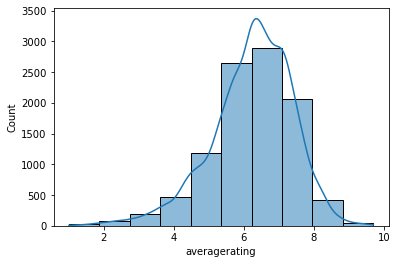

In [24]:
sns.histplot(data=movies_df, x='averagerating', bins=10, kde=True)

In [25]:
# Check for duplicate primary_title values
duplicated_movies = movies_df[movies_df.duplicated(subset=['primary_title'], keep=False)]
duplicated_movies.head(10)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes


In [26]:
# Create 'cleaned_data' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save movie_basics_df to a CSV file
movies_df.to_csv(f'{output_folder}/movies_df.csv', index=False)

print("DataFrames have been successfully saved to the 'extracted' folder.")

DataFrames have been successfully saved to the 'extracted' folder.


## Conclusion

In this notebook, we performed the following key steps:

1. **Data Extraction:** Extracted and loaded data from a SQLite database and CSV files.
2. **Data Cleaning:**
   - Standardized text columns and removed duplicates.
   - Handled missing values by dropping rows with critical missing data.
   - Filtered movies based on runtime and number of votes to focus on relevant data.
   - Resolved duplicate movie titles by appending release years.
3. **Data Transformation:**
   - Merged datasets to create a comprehensive DataFrame for analysis.
   - Filtered movies in the top 25% based on the number of votes.
4. **Data Visualization:**
   - Visualized the distribution of average ratings to understand audience preferences.

The cleaned and processed data has been saved to CSV files for further analysis. These datasets are now ready to be used for exploratory data analysis, modeling, or other analytical tasks.

### Next Steps
- Perform exploratory data analysis (EDA) to uncover insights and trends in the movies.
- Use the cleaned data for predictive modeling or other advanced analyses.

## MOVIE BUDGETS

In [27]:
# load the data
movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz', encoding='utf-8')
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Introduction to Movie Budgets

The **movie budgets** dataset provides critical financial insights into the production and revenue aspects of movies. It includes key metrics such as:

1. **Production Budget**: The total cost incurred in creating the movie, including expenses for cast, crew, sets, and post-production.
2. **Domestic Gross**: The revenue generated by the movie within its home country.
3. **Worldwide Gross**: The total revenue earned globally, combining domestic and international earnings.

This dataset is essential for analyzing:
    - the financial performance of movies
    - identifying profitable trends
    - understanding the relationship between production budgets and revenue. 
    - It can also help in comparing the financial success of movies across different genres, release years, and regions.

## Data Preparation

### Data Cleaning

1. **Renaming Columns**:
   - The column `movie` is renamed to `movie_name` for better clarity and consistency with other datasets.

2. **Converting `release_date` to Datetime Format**:
   - The `release_date` column is converted to a datetime format using `pd.to_datetime()`. This ensures that the column can be used for date-based operations, such as extracting the year or filtering by date.

3. **Standardizing the `movie_name` Column**:
   - The `movie_name` column is cleaned by:
     - Stripping leading and trailing spaces using `.str.strip()`.
     - Converting all text to lowercase using `.str.lower()`.
   - This standardization ensures consistency in movie names, making it easier to identify duplicates or merge with other datasets.

In [28]:
# Rename 'movie' column to 'movie_name'
movie_budgets_df.rename(columns={'movie': 'movie_name'}, inplace=True)

# Convert 'release_date' to datetime format
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Standardize the 'movie_name' column
movie_budgets_df['movie_name'] = movie_budgets_df['movie_name'].str.strip().str.lower()

# Display the updated column names
print(movie_budgets_df.columns)
# Display the updated DataFrame
print(movie_budgets_df.dtypes)

Index(['id', 'release_date', 'movie_name', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')
id                            int64
release_date         datetime64[ns]
movie_name                   object
production_budget            object
domestic_gross               object
worldwide_gross              object
dtype: object


In [29]:
# Check for missing and null values
movie_budgets_df.isna().sum()

id                   0
release_date         0
movie_name           0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### Data Transformation: 

Converting data into a more useful format 
1. **Extract Year**: The `dt.year` attribute extracts the year from the `release_date` column.
2. **Identify Duplicates**: The `duplicated()` method identifies duplicate `movie_name` entries.

    - It identifies rows with duplicate movie names and then modifies the 'movie_name' for these duplicates by appending their release year in parentheses. 
    - This is to distinguish between movies with the same title but different release dates, creating more unique identifiers.
    
3. **Update Names**: For duplicates, the `movie_name` is updated by appending the release year in parentheses.

This ensures that duplicate movie names are uniquely identified by their release year.

In [30]:
# check for duplicates using movie_name and release_date
duplicates = movie_budgets_df[movie_budgets_df.duplicated(subset=['movie_name'], keep=False)]
# Display duplicates sorted by movie_name in ascending order
duplicates = duplicates.sort_values(by='movie_name', ascending=True)
print(duplicates.shape)
duplicates.head(10)

(165, 6)


,id,release_date,movie_name,production_budget,domestic_gross,worldwide_gross
4270,71,1954-12-23,"20,000 leagues under the sea","$5,000,000","$28,200,000","$28,200,000"
5614,15,1916-12-24,"20,000 leagues under the sea","$200,000","$8,000,000","$8,000,000"
1648,49,2010-04-30,a nightmare on elm street,"$35,000,000","$63,075,011","$117,729,621"
5016,17,1984-11-09,a nightmare on elm street,"$1,800,000","$25,504,513","$25,504,513"
2032,33,1992-11-11,aladdin,"$28,000,000","$217,350,219","$504,050,219"
80,81,2019-05-24,aladdin,"$182,000,000","$246,734,314","$619,234,314"
50,51,2010-03-05,alice in wonderland,"$200,000,000","$334,191,110","$1,025,491,110"
4759,60,1951-07-28,alice in wonderland,"$3,000,000",$0,$0
4120,21,1956-10-17,around the world in 80 days,"$6,000,000","$42,000,000","$42,000,000"
340,41,2004-06-16,around the world in 80 days,"$110,000,000","$24,004,159","$72,004,159"


### Append release_year to duplicate movie names

1.  **Extracts the year:** It creates a new column called `release_year` by extracting the year from the `release_date` column.
2.  **Identifies duplicates:** It checks for rows with duplicate values in the `movie_name` column, keeping all occurrences of the duplicates.
3.  **Updates duplicate movie names:** For the identified duplicate movie names, it appends the release year in parentheses to the `movie_name` to make them unique.
4.  **Displays the result:** Finally, it displays the first few rows of the updated DataFrame, showing only the `movie_name` and `release_year` columns.

In [31]:
# Extract the year from the 'release_date' column
movie_budgets_df['release_year'] = movie_budgets_df['release_date'].dt.year

# Check for duplicates in 'movie_name'
duplicates = movie_budgets_df[movie_budgets_df.duplicated(subset=['movie_name'], keep=False)]

# Update 'movie_name' for duplicates by appending the release year
movie_budgets_df.loc[duplicates.index, 'movie_name'] = (
    movie_budgets_df.loc[duplicates.index, 'movie_name'] + 
    " (" + movie_budgets_df.loc[duplicates.index, 'release_year'].astype(str) + ")"
)

# Display the updated DataFrame
movie_budgets_df[['movie_name', 'release_year']].head()

,movie_name,release_year
0,avatar,2009
1,pirates of the caribbean: on stranger tides,2011
2,dark phoenix,2019
3,avengers: age of ultron,2015
4,star wars ep. viii: the last jedi,2017


Essentially, we've cleaned and prepared the 'movie_name' column to handle potential duplicate entries by making them distinct using their release years. We've also added a separate 'release_year' column for easier access to the movie's release year

In [32]:
# Filter movie names containing the word 'alice in wonderland'
avenger_movies = movie_budgets_df[movie_budgets_df['movie_name'].str.contains('alice in wonderland', case=False, na=False)]

# Display the filtered DataFrame
print(f"Number of movies with 'alice in wonderland' in the name: {avenger_movies.shape[0]}")
avenger_movies[['movie_name', 'release_year']].head()

Number of movies with 'alice in wonderland' in the name: 2


,movie_name,release_year
50,alice in wonderland (2010),2010
4759,alice in wonderland (1951),1951


### Standardization of 'production\_budget', 'domestic\_gross', and 'worldwide\_gross' columns

This focuses on **cleaning and converting financial columns** in the `movie_budgets_df` DataFrame.

For each of the 'production\_budget', 'domestic\_gross', and 'worldwide\_gross' columns, it performs the following actions:

1.  **Removes special characters:** It converts the column to string format, then uses regular expressions to remove dollar signs (\$) and commas (,).

2.  **Converts to numeric:** It convertS the cleaned strings to a numeric format. The `errors='coerce'` argument ensures that any values that cannot be converted to numbers will be replaced with `NaN` (Not a Number).

3.  **Converts to integer:** Finally, it converts the numeric data type to `Int64`, which is a pandas integer type that can handle missing values (represented by `NaN`).

**This cleans the budget and gross revenue columns by removing formatting characters and converting them into a usable integer format that can handle potential missing data.**

This is crucial for performing calculations and analysis on the financial aspects of the movies.

In [33]:
# Remove special characters ('$' and ',') and convert to Int64
movie_budgets_df['production_budget'] = pd.to_numeric(
    movie_budgets_df['production_budget'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce'
).astype('Int64')

movie_budgets_df['domestic_gross'] = pd.to_numeric(
    movie_budgets_df['domestic_gross'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce'
).astype('Int64')

movie_budgets_df['worldwide_gross'] = pd.to_numeric(
    movie_budgets_df['worldwide_gross'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce'
).astype('Int64')

# Display the updated DataFrame
print(movie_budgets_df.dtypes)
movie_budgets_df.head()

id                            int64
release_date         datetime64[ns]
movie_name                   object
production_budget             Int64
domestic_gross                Int64
worldwide_gross               Int64
release_year                  int64
dtype: object


,id,release_date,movie_name,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009
1,2,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,2011
2,3,2019-06-07,dark phoenix,350000000,42762350,149762350,2019
3,4,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,2015
4,5,2017-12-15,star wars ep. viii: the last jedi,317000000,620181382,1316721747,2017


**Identifying and removing columns from a DataFrame that are not necessary or useful for analysis.**

This process streamlines the dataset by:

* **Reducing dimensionality:** Making the DataFrame easier to work with and potentially improving the performance of analytical models.
* **Removing noise:** Eliminating columns that don't contribute meaningful information and could even introduce confusion or bias.
* **Focusing on relevant data:** Ensuring that subsequent analysis is concentrated on the variables that truly matter for the research questions or objectives.

In [34]:
# Drop rows where both 'domestic_gross' and 'worldwide_gross' are 0
movie_budgets_df = movie_budgets_df[
    ~((movie_budgets_df['domestic_gross'] == 0) & (movie_budgets_df['worldwide_gross'] == 0))
]

# Display the updated DataFrame shape
print(f"Shape after dropping rows with zero gross: {movie_budgets_df.shape}")

Shape after dropping rows with zero gross: (5415, 7)


In [35]:
output_folder = './extractedData'
os.makedirs(output_folder, exist_ok=True)

# Save movie_basics_df to a CSV file
movie_budgets_df.to_csv(f'{output_folder}/cleaned_movie_budgets_df.csv', index=False)

print("DataFrames have been successfully saved to the 'extracted' folder.")

DataFrames have been successfully saved to the 'extracted' folder.


- The **movie_budgets** dataset provides insights into the financial aspects of movies, including production costs, domestic revenue, and worldwide earnings. 
- It is cleaned by standardizing column names, handling duplicates, and converting financial data into numeric formats.
- This dataset is crucial for analyzing profitability, trends, and the relationship between budgets and revenues.

## COMBINE SQL DATA WITH MOVIE BUDGETS

- To combine `movies_df.csv` and `movie_budgets_df`, the datasets are merged on the `movie_name` column using an inner join. 
- This ensures that only movies present in both datasets are included. The resulting combined dataset integrates movie details with budget and revenue information, enabling comprehensive analysis of financial performance and trends.

In [36]:
# Load the cleaned movies_df.csv
movies_df = pd.read_csv('./cleaned_data/movies_df.csv')
movie_budgets_df = pd.read_csv('./extractedData/cleaned_movie_budgets_df.csv')

movies_df.info()
print('--------' * 20)
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10010 entries, 0 to 10009
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         10010 non-null  object 
 1   primary_title    10010 non-null  object 
 2   start_year       10010 non-null  int64  
 3   runtime_minutes  10010 non-null  int64  
 4   genres           10010 non-null  object 
 5   averagerating    10010 non-null  float64
 6   numvotes         10010 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 547.5+ KB
----------------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5415 non-null   int64 
 1   r

**Renaming columns and converting the release year to a datetime object** 

This standardizes the column names for 'movie\_name' and 'release\_year'

In [37]:
# change primary_title to movie_name, start_year to release_year
movies_df.rename(columns={'primary_title': 'movie_name', 'start_year': 'release_year'}, inplace=True)


This combines movie details (from `movies_df`) with budget and revenue information (from `movie_budgets_df`) into a single DataFrame for further analysis. It ensures that only movies present in both datasets are included.
1. **Merging DataFrames**:
   - The `movies_df` and `movie_budgets_df` DataFrames are merged on the `movie_name` column.
   - An **inner join** is used, meaning only rows with matching `movie_name` values in both DataFrames are included in the resulting `combined_data` DataFrame.

2. **Adding Suffixes**:
   - Suffixes `('_movies', '_budgets')` are added to distinguish columns with the same name in both DataFrames (e.g., `release_year_movies` and `release_year_budgets`).

3. **Displaying Results**:
   - The shape of the merged DataFrame (`combined_data`) is printed to show the number of rows and columns.
   - The first few rows of the merged DataFrame are displayed using `.head()` to verify the merge.

In [38]:
# Merge movies_df and movie_budgets_df on 'movie_name'
combined_data = pd.merge(
    movies_df,
    movie_budgets_df,
    on='movie_name',
    how='inner',  # Use 'inner' to keep only matching rows
    suffixes=('_movies', '_budgets')  # Add suffixes to distinguish columns
)

# Display the shape and the first few rows of the combined DataFrame
print(f"Shape of the combined DataFrame: {combined_data.shape}")
combined_data.head()

Shape of the combined DataFrame: (1426, 13)


,movie_id,movie_name,release_year_movies,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_year_budgets
0,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,26,2012-12-31,45000000,0,73706,2012
1,tt0359950,the secret life of walter mitty,2013,114,"adventure,comedy,drama",7.3,275300,37,2013-12-25,91000000,58236838,187861183,2013
2,tt0365907,a walk among the tombstones,2014,114,"action,crime,drama",6.5,105116,67,2014-09-19,28000000,26017685,62108587,2014
3,tt0369610,jurassic world,2015,124,"action,adventure,sci-fi",7.0,539338,34,2015-06-12,215000000,652270625,1648854864,2015
4,tt0376136,the rum diary,2011,119,"comedy,drama",6.2,94787,16,2011-10-28,45000000,13109815,21544732,2011


To check if the release_year_movies and release_year_budgets columns do not match in the combined_data DataFrame

1. **Filter Rows with Mismatched Years**:
   - The condition `combined_data['release_year_movies'] != combined_data['release_year_budgets']` identifies rows where the release years in the two columns do not match.

2. **Count Mismatched Rows**:
   - `mismatched_years.shape[0]` gives the total number of rows with mismatched release years.

3. **Display Results**:
   - The `head()` method displays the first few rows of the mismatched data, showing the `movie_name`, `release_year_movies`, and `release_year_budgets` columns for inspection.

In [39]:
# Filter rows where the absolute difference between release_year_movies and release_year_budgets is greater than 10
large_mismatched_years = combined_data[
    (combined_data['release_year_movies'] - combined_data['release_year_budgets']).abs() > 10
]

# Display the count and the mismatched rows
print(f"Number of rows with a year difference greater than 10: {large_mismatched_years.shape[0]}")
large_mismatched_years[['movie_name', 'release_year_movies', 'release_year_budgets']].head()

Number of rows with a year difference greater than 10: 45


,movie_name,release_year_movies,release_year_budgets
8,action jackson,2014,1988
106,fair game,2010,1995
404,no man's land,2013,2001
433,vampires,2010,1998
464,playing for keeps,2012,1986


In [40]:
# Shape of the combined DataFrame before dropping rows
print(f"Shape of the combined DataFrame before dropping rows: {combined_data.shape}")   

# DROP ROWS WHERE THE YEAR DIFFERENCE IS GREATER THAN 10
combined_data = combined_data[
    (combined_data['release_year_movies'] - combined_data['release_year_budgets']).abs() <= 10
]

print(f"Shape of the combined DataFrame after dropping rows: {combined_data.shape}")

Shape of the combined DataFrame before dropping rows: (1426, 13)
Shape of the combined DataFrame after dropping rows: (1381, 13)


In [41]:
# We check if the data types are consistent across the combined DataFrame
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1425
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              1381 non-null   object 
 1   movie_name            1381 non-null   object 
 2   release_year_movies   1381 non-null   int64  
 3   runtime_minutes       1381 non-null   int64  
 4   genres                1381 non-null   object 
 5   averagerating         1381 non-null   float64
 6   numvotes              1381 non-null   int64  
 7   id                    1381 non-null   int64  
 8   release_date          1381 non-null   object 
 9   production_budget     1381 non-null   int64  
 10  domestic_gross        1381 non-null   int64  
 11  worldwide_gross       1381 non-null   int64  
 12  release_year_budgets  1381 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 151.0+ KB


In [42]:
# check for duplicates in the combined DataFrame based on 'movie_name'
duplicates_combined = combined_data[combined_data.duplicated(subset=['movie_name'], keep=False)]
duplicates_combined

,movie_id,movie_name,release_year_movies,runtime_minutes,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,release_year_budgets


In [43]:
# drop irelevant columns
drop_columns = [ 'id', 'release_year_budgets']
combined_data.drop(columns=drop_columns, inplace=True)

# Rename release_year_movies to release_year
combined_data.rename(columns={'release_year_movies': 'release_year'}, inplace=True)


In [44]:
# This will display the data types of the remaining columns in the combined DataFrame
combined_data.dtypes

movie_id              object
movie_name            object
release_year           int64
runtime_minutes        int64
genres                object
averagerating        float64
numvotes               int64
release_date          object
production_budget      int64
domestic_gross         int64
worldwide_gross        int64
dtype: object

In [45]:
# Convert 'release_date' to datetime format
combined_data['release_date'] = pd.to_datetime(combined_data['release_date'])

# Display the updated DataFrame to confirm the change
print(combined_data.dtypes)

movie_id                     object
movie_name                   object
release_year                  int64
runtime_minutes               int64
genres                       object
averagerating               float64
numvotes                      int64
release_date         datetime64[ns]
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
dtype: object


In [46]:
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save movie_basics_df to a CSV file
combined_data.to_csv(f'{output_folder}/movie_budgets.csv', index=False)

print("DataFrames have been successfully saved to the 'extracted' folder.")

DataFrames have been successfully saved to the 'extracted' folder.


### Conclusion:

The `movie_budgets_df` dataset is successfully cleaned and prepared for analysis by:
 - renaming columns, 
 - converting `release_date` to datetime format, 
 - standardizing `movie_name`
 - cleaning financial columns. 
 
It is then merged with `movies_df` to create a combined dataset, ensuring only matching movies were included. 
This combined dataset is now ready for further analysis, with mismatched release years identified and irrelevant columns removed for clarity and focus.

# Introduction `persons`, `writers`, `directors`, and `principals`

This focuses on extracting, cleaning, and preparing data related to persons involved in movies, including writers, directors, and actors. The goal is to create a comprehensive dataset that combines information about movies, their budgets, and the individuals who contributed to their creation.

### Objectives:
1. **Data Extraction:**
   - Extract data from a SQLite database and CSV files.
   - Load tables such as `persons`, `writers`, `directors`, and `principals` into pandas DataFrames.

2. **Data Cleaning:**
   - Handle missing values and duplicates.
   - Remove irrelevant columns and rows.
   - Standardize and group data for clarity and consistency.

3. **Data Transformation:**
   - Merge datasets to link movies with their writers, directors, and actors.
   - Aggregate and compress data to ensure unique and meaningful representations.

4. **Data Export:**
   - Save the cleaned and merged datasets to CSV files for further analysis.

### Key Outputs:
- A cleaned `persons_df` containing information about individuals involved in movies.
- Merged datasets linking movies with their writers, directors, and actors.
- A final dataset (`final_merged_df_2`) combining movie budgets, writers, directors, and actors for comprehensive analysis.

This notebook serves as a critical step in preparing the data for exploratory data analysis (EDA) and modeling, ensuring that the datasets are clean, consistent, and ready for further use.

In [47]:
# connect to the SQLite database
conn = sqlite3.connect('./extractedData/im.db')
cursor = conn.cursor()

In [48]:
# read the persons table into a pandas DataFrame
# and display its information
persons_df = pd.read_sql("SELECT * FROM persons;", conn)
persons_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [49]:
# Check for missing values
persons_df.isnull().sum()

person_id                  0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
dtype: int64

## Data Preparation for Analysis
### Data Cleaning

   - Handle missing values and duplicates.
   - Remove irrelevant columns and rows.
   - Standardize and group data for clarity and consistency.

In [50]:
# Drop rows where death_year is not null
persons_df = persons_df[persons_df['death_year'].isna()]

# Drop the 'birth_year', 'death_year' columns
persons_df = persons_df.drop(columns=['birth_year', 'death_year'])

# Reset the index of the DataFrame
persons_df.reset_index(drop=True, inplace=True)


In [51]:
# Display the updated DataFrame
persons_df.dtypes

person_id             object
primary_name          object
primary_profession    object
dtype: object

duplicate_persons_primary_name helps identify and preview individuals with non-unique primary names in the dataset. We can say that many people can share the same name. We can not use primary_name to clean our data

In [52]:
# view duplicates using primary_name
duplicate_persons_primary_name = persons_df[persons_df.duplicated(subset=['primary_name'], keep=False)]
duplicate_persons_primary_name = duplicate_persons_primary_name.sort_values('primary_name')
duplicate_persons_primary_name.head()

,person_id,primary_name,primary_profession
381053,nm8956236,A. Venkatesh,producer
151115,nm1701176,A. Venkatesh,"cinematographer,camera_department,editor"
124660,nm10275444,A. Venkatesh,director
273669,nm4062141,A. Venkatesh,"director,actor,writer"
429984,nm6758318,A.J. Khan,producer


In [53]:
# Drop rows where primary_profession is 'miscellaneous' only
persons_df = persons_df[persons_df['primary_profession'].str.strip().str.lower() != 'miscellaneous']

# Display the updated DataFrame
print(f"Shape after dropping rows with primary_profession as 'miscellaneous': {persons_df.shape}")

Shape after dropping rows with primary_profession as 'miscellaneous': (599028, 3)


In [54]:
# Check for missing values again
persons_df.isna().sum()

person_id                 0
primary_name              0
primary_profession    50548
dtype: int64

In [55]:
# Display the updated DataFrame information
print("Updated DataFrame information after cleaning:")
persons_df.info()

Updated DataFrame information after cleaning:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 599028 entries, 0 to 599864
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   person_id           599028 non-null  object
 1   primary_name        599028 non-null  object
 2   primary_profession  548480 non-null  object
dtypes: object(3)
memory usage: 18.3+ MB


In [56]:
# close the database connection
conn.close()

In [57]:
# Create 'extracted' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save persons_df to a CSV file
persons_df.to_csv(f'{output_folder}/cleaned_persons_df.csv', index=False)

print("DataFrames have been successfully saved to the 'extracted' folder.")

DataFrames have been successfully saved to the 'extracted' folder.


## Introduction to Writers

The **writers** dataset provides information about individuals who contributed to the writing of movies. 

It includes details such as `movie_id` and `person_id`, linking movies to their respective writers. 

This dataset is essential for analyzing the impact of writers on movie success and for merging with other datasets to create a comprehensive view of movie production.

In [58]:
conn = sqlite3.connect('./extractedData/im.db')
cursor = conn.cursor()

In [59]:
writers_df = pd.read_sql("SELECT * FROM writers;", conn)
print(writers_df.shape)
writers_df.head()


(255873, 2)


,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087


In [60]:
# Check for missing values
writers_df.isna().sum()

movie_id     0
person_id    0
dtype: int64

In [61]:
# view duplicates using movie_id and person_id

duplicate_writers = writers_df[writers_df.duplicated(subset=['movie_id', 'person_id'], keep=False)]

duplicate_writers.count()

movie_id     104011
person_id    104011
dtype: int64

### Data Cleaning for Analysis

The data preparation for the **writers** dataset involved extracting data from a SQLite database, removing duplicates, and ensuring unique entries for `movie_id` and `person_id`.

This cleaned dataset was then saved for further analysis and merging with other datasets to link movies with their respective writers.

In [62]:
# drop duplicates from the DataFrame. retain the first occurrence
writers_df = writers_df.drop_duplicates(subset=['movie_id', 'person_id'], keep='first')

# check for duplicates in the DataFrame
duplicate_writers = writers_df.duplicated(subset=['movie_id', 'person_id'])

# count the number of duplicates
duplicate_writers.count()

178352

In [63]:
writers_df.shape

(178352, 2)

In [64]:
# Create 'cleaned_data' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save writers_df to a CSV file
writers_df.to_csv(f'{output_folder}/cleaned_writers_df.csv', index=False)

print("writers_df has been successfully saved to the 'cleaned_data' folder.")

writers_df has been successfully saved to the 'cleaned_data' folder.


## Directors

The **directors** dataset contains information linking movies to their respective directors using `movie_id` and `person_id`. 

The data preparation involved extracting it from a SQLite database, removing duplicates, and ensuring unique entries. 

This cleaned dataset was saved for further analysis and integration with other datasets to analyze the role of directors in movie production.

In [65]:
directors_df = pd.read_sql("SELECT * FROM directors;", conn)
print(directors_df.shape)
directors_df.head()

(291174, 2)


,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [66]:
# Check for missing values
directors_df.isna().sum()

movie_id     0
person_id    0
dtype: int64

In [67]:
# view duplicates using movie_id and person_id

duplicate_directors = directors_df[directors_df.duplicated(subset=['movie_id', 'person_id'], keep='first')]

duplicate_directors.count()

movie_id     127639
person_id    127639
dtype: int64

In [68]:
# drop duplicates from the DataFrame
directors_df = directors_df.drop_duplicates(subset=['movie_id', 'person_id'], keep='first')

# check for duplicates in the DataFrame
duplicate_directors = directors_df.duplicated(subset=['movie_id', 'person_id'])

# count the number of duplicates
duplicate_directors.count()

163535

In [69]:
# Create 'cleaned_data' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save writers_df to a CSV file
directors_df.to_csv(f'{output_folder}/cleaned_directors_df.csv', index=False)

print("directors_df has been successfully saved to the 'cleaned_data' folder.")

directors_df has been successfully saved to the 'cleaned_data' folder.


In [70]:
#  close the database connection
conn.close()

In [71]:
cleaned_persons_df = pd.read_csv('./cleaned_data/cleaned_persons_df.csv')
cleaned_persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599028 entries, 0 to 599027
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   person_id           599028 non-null  object
 1   primary_name        599028 non-null  object
 2   primary_profession  548480 non-null  object
dtypes: object(3)
memory usage: 13.7+ MB


In [72]:
# get cleaned writers_df and cleaned directors_df
cleaned_writers_df = pd.read_csv('./cleaned_data/cleaned_writers_df.csv')
cleaned_writers_df.info()

print('----'*20)

cleaned_directors_df = pd.read_csv('./cleaned_data/cleaned_directors_df.csv')
cleaned_directors_df.info()
# check the shape of cleaned_writers_df and cleaned_directors_df
cleaned_writers_df.shape, cleaned_directors_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178352 entries, 0 to 178351
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   178352 non-null  object
 1   person_id  178352 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163535 entries, 0 to 163534
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   163535 non-null  object
 1   person_id  163535 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


((178352, 2), (163535, 2))

### Fetch the movie_budgets and combine directors_details and writers_details 

To fetch the `movie_budgets` and combine `directors_details` and `writers_details`, the process involves:

1. **Loading Cleaned Data**: The cleaned `movie_budgets.csv` file is loaded into a DataFrame.
2. **Merging Director and Writer Details**: The `directors_details` and `writers_details` DataFrames are created by merging the `cleaned_directors_df` and `cleaned_writers_df` with `cleaned_persons_df` to include names and professions.
3. **Combining All Data**: The `movie_budgets_df` is merged with `directors_details` and `writers_details` on the `movie_id` column to create a comprehensive dataset linking movies with their budgets, directors, and writers.

In [73]:
# combine movie_budgets, directors_details and writers_details
movie_budgets_df = pd.read_csv('./cleaned_data/movie_budgets.csv')
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1381 non-null   object 
 1   movie_name         1381 non-null   object 
 2   release_year       1381 non-null   int64  
 3   runtime_minutes    1381 non-null   int64  
 4   genres             1381 non-null   object 
 5   averagerating      1381 non-null   float64
 6   numvotes           1381 non-null   int64  
 7   release_date       1381 non-null   object 
 8   production_budget  1381 non-null   int64  
 9   domestic_gross     1381 non-null   int64  
 10  worldwide_gross    1381 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 118.8+ KB


To get director and writer names from `cleaned_persons_df`, you merge it with `cleaned_directors_df` and `cleaned_writers_df` on the `person_id` column as follows:

1. **Merge Directors**:
   - Merge `cleaned_directors_df` with `cleaned_persons_df` on the `person_id` column using an inner join.
   - This adds the `primary_name` (director's name) and `primary_profession` (director's profession) columns to the `cleaned_directors_df`.

2. **Merge Writers**:
   - Similarly, merge `cleaned_writers_df` with `cleaned_persons_df` on the `person_id` column using an inner join.
   - This adds the `primary_name` (writer's name) and `primary_profession` (writer's profession) columns to the `cleaned_writers_df`.

3. **Result**:
   - The resulting `directors_details` and `writers_details` DataFrames contain enriched information about directors and writers, including their names and professions, linked to their respective `movie_id`.

This process ensures that the `person_id` in the directors and writers datasets is matched with the corresponding details in the `cleaned_persons_df`.

In [74]:
# Merge cleaned_directors_df with cleaned_persons_df to get director names
directors_details = pd.merge(cleaned_directors_df, cleaned_persons_df, on='person_id', how='inner')

# Merge cleaned_writers_df with cleaned_persons_df to get writer names
writers_details = pd.merge(cleaned_writers_df, cleaned_persons_df, on='person_id', how='inner')

# Save the resulting DataFrames to CSV files
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)
directors_details.to_csv(f'{output_folder}/directors_details.csv', index=False)
writers_details.to_csv(f'{output_folder}/writers_details.csv', index=False)

# Display the shapes and first few rows of the resulting DataFrames 
writers_details.head()

,movie_id,person_id,primary_name,primary_profession
0,tt0285252,nm0899854,Tony Vitale,"producer,director,writer"
1,tt0438973,nm0175726,Steve Conrad,"writer,producer,director"
2,tt2358925,nm0175726,Steve Conrad,"writer,producer,director"
3,tt2543472,nm0175726,Steve Conrad,"writer,producer,director"
4,tt0359950,nm0175726,Steve Conrad,"writer,producer,director"


To merge `movie_budgets_df`, `directors_details`, and `writers_details` on the `movie_id` column:

1. **First Merge**:
   - Merge `movie_budgets_df` with `directors_details` on the `movie_id` column using an **inner join**.
   - This ensures that only rows with matching `movie_id` in both DataFrames are included.
   - The result contains movie budget information along with director details.

2. **Second Merge**:
   - Merge the resulting `merged_df` with `writers_details` on the `movie_id` column using another **inner join**.
   - This adds writer details to the dataset, ensuring that only movies with matching `movie_id` in all three DataFrames are included.

3. **Column Renaming**:
   - Rename columns for clarity, such as distinguishing between director and writer `person_id` or names.

4. **Result**:
   - The final `merged_df` contains combined information about movie budgets, directors, and writers, all linked by the `movie_id`.

This process ensures a detailed dataset where each movie is enriched with its budget, director, and writer details.

In [75]:
# Merge movie_budgets_df, directors_details, and writers_details on 'movie_id'
merged_df = pd.merge(movie_budgets_df, directors_details, on='movie_id', how='inner')
merged_df = pd.merge(merged_df, writers_details, on='movie_id', how='inner')

# Rename columns for clarity
merged_df.rename(columns={
    'person_id_x': 'director_person_id',  # Rename director's person_id column
    'person_id_y': 'writer_person_id',    # Rename writer's person_id column    
}, inplace=True)

# Display the resulting DataFrame
print(f"Shape of the merged DataFrame: {merged_df.shape}")
merged_df.head()

Shape of the merged DataFrame: (3998, 17)


,movie_id,movie_name,release_year,runtime_minutes,genres,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,director_person_id,primary_name_x,primary_profession_x,writer_person_id,primary_name_y,primary_profession_y
0,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0440415,Lawrence Kasanoff,"producer,writer,director",nm0220297,Sean Catherine Derek,"writer,miscellaneous,producer"
1,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0440415,Lawrence Kasanoff,"producer,writer,director",nm0440415,Lawrence Kasanoff,"producer,writer,director"
2,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0440415,Lawrence Kasanoff,"producer,writer,director",nm0923312,Joshua Wexler,"producer,writer,director"
3,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0440415,Lawrence Kasanoff,"producer,writer,director",nm0295165,Brent V. Friedman,"producer,writer,director"
4,tt0249516,foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0440415,Lawrence Kasanoff,"producer,writer,director",nm0841854,Rebecca Swanson,"writer,miscellaneous"


In [76]:
merged_df.columns

Index(['movie_id', 'movie_name', 'release_year', 'runtime_minutes', 'genres',
       'averagerating', 'numvotes', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'director_person_id',
       'primary_name_x', 'primary_profession_x', 'writer_person_id',
       'primary_name_y', 'primary_profession_y'],
      dtype='object')

In [77]:
# Rename columns for clarity
merged_df.rename(columns={    
    'primary_name_x': 'director_name',  # Rename director's name column
    'primary_name_y': 'writer_name',    # Rename writer's name column
    'primary_profession_x': 'director_profession',  # Rename director's profession column
    'primary_profession_y': 'writer_profession',    # Rename writer's profession column
}, inplace=True)

To drop duplicate values in `director_ids`, `director_names`, `writer_ids`, and `writer_names`



In [84]:
# Group directors' IDs and names by movie_id, ensuring unique values
directors_grouped = merged_df.groupby('movie_id').agg({
    'director_person_id': lambda x: ', '.join(map(str, sorted(set(x)))),
    'director_name': lambda x: ', '.join(sorted(set(x)))
}).reset_index()

# Rename columns for directors
directors_grouped.rename(columns={
    'director_person_id': 'director_ids',
    'director_name': 'director_names'
}, inplace=True)

# Group writers' IDs and names by movie_id, ensuring unique values
writers_grouped = merged_df.groupby('movie_id').agg({
    'writer_person_id': lambda x: ', '.join(map(str, sorted(set(x)))),
    'writer_name': lambda x: ', '.join(sorted(set(x)))
}).reset_index()

# Rename columns for writers
writers_grouped.rename(columns={
    'writer_person_id': 'writer_ids',
    'writer_name': 'writer_names'
}, inplace=True)

# Merge the grouped data back into a single DataFrame
director_writers_df = pd.merge(directors_grouped, writers_grouped, on='movie_id', how='inner')

# Display the resulting DataFrame
print(f"Shape of the compressed DataFrame: {director_writers_df.shape}")
director_writers_df.tail()

Shape of the compressed DataFrame: (1362, 5)


,movie_id,director_ids,director_names,writer_ids,writer_names
1357,tt8043306,nm6773153,Ahsan Rahim,"nm3773554, nm6511211, nm6773153","Ahsan Rahim, Ali Zafar, Danyal Zafar"
1358,tt8155288,nm0484907,Christopher Landon,"nm0484907, nm1245146","Christopher Landon, Scott Lobdell"
1359,tt8580348,nm1919456,Manolo Caro,"nm0002645, nm0182499, nm0712330, nm2601560, nm...","Filippo Bologna, Paola Mammini, Paolo Costella..."
1360,tt8632862,nm0601619,Michael Moore,nm0601619,Michael Moore
1361,tt9024106,"nm0465484, nm0813301","Cary Solomon, Chuck Konzelman","nm0465484, nm0813301","Cary Solomon, Chuck Konzelman"


In [79]:
# check for null values in the DataFrame
director_writers_df.isna().sum()

movie_id          0
director_ids      0
director_names    0
writer_ids        0
writer_names      0
dtype: int64

In [80]:
# check if nm0004056 is in the director_ids
director_writers_df['director_ids'].str.contains('nm0004056').any()

True



### Explanation:
1. **Remove Duplicates**:
   - Use `set(x)` to ensure unique values for `director_person_id`, `director_name`, `writer_person_id`, and `writer_name`.
   - Use `sorted(set(x))` to sort the unique values for consistent ordering.

2. **Aggregation**:
   - Use `', '.join(...)` to concatenate the unique values into a single string.

3. **Result**:
   - The resulting `compressed_df` will have unique and sorted values in `director_ids`, `director_names`, `writer_ids`, and `writer_names`.

To merge `director_writers_df` and `movie_budgets_df` on `movie_id`, you can use the following code:



In [85]:
# Merge director_writers_df and movie_budgets_df on 'movie_id'
director_writers_eda = pd.merge(director_writers_df, movie_budgets_df, on='movie_id', how='inner')

# Display the resulting DataFrame
print(f"Shape of the final merged DataFrame: {director_writers_eda.shape}")
director_writers_eda.head()

Shape of the final merged DataFrame: (1362, 15)


,movie_id,director_ids,director_names,writer_ids,writer_names,movie_name,release_year,runtime_minutes,genres,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,nm0440415,Lawrence Kasanoff,"nm0220297, nm0295165, nm0440415, nm0841854, nm...","Brent V. Friedman, Joshua Wexler, Lawrence Kas...",foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706
1,tt0359950,nm0001774,Ben Stiller,nm0175726,Steve Conrad,the secret life of walter mitty,2013,114,"adventure,comedy,drama",7.3,275300,2013-12-25,91000000,58236838,187861183
2,tt0365907,nm0291082,Scott Frank,"nm0088747, nm0291082","Lawrence Block, Scott Frank",a walk among the tombstones,2014,114,"action,crime,drama",6.5,105116,2014-09-19,28000000,26017685,62108587
3,tt0369610,nm1119880,Colin Trevorrow,"nm0415425, nm0798646, nm1119880, nm2081046","Amanda Silver, Colin Trevorrow, Derek Connolly...",jurassic world,2015,124,"action,adventure,sci-fi",7.0,539338,2015-06-12,215000000,652270625,1648854864
4,tt0376136,nm0732430,Bruce Robinson,nm0732430,Bruce Robinson,the rum diary,2011,119,"comedy,drama",6.2,94787,2011-10-28,45000000,13109815,21544732




### Explanation:
1. **Merge Operation**:
   - `pd.merge(director_writers_df, movie_budgets_df, on='movie_id', how='inner')` merges the two DataFrames on the `movie_id` column using an inner join.
   - This ensures that only rows with matching `movie_id` in both DataFrames are included.

2. **Result**:
   - The resulting `director_writers_eda` contains all columns from both `director_writers_df` and `movie_budgets_df`.

### Merge movies with principals and actors


To merge movies with principals and actors, the process involves the following steps:

1. **Load the Principals Table**:
   - Extract the `principals` table from the SQLite database into a DataFrame (`principals_df`).
   - This table contains information about individuals associated with movies, such as actors, directors, and other roles.

2. **Filter for Actors**:
   - Filter the `principals_df` to include only rows where the `category` column is `'actor'`.
   - This creates a new DataFrame (`actors_df`) containing only actor-related data.

3. **Merge with Cleaned Persons Data**:
   - Merge `actors_df` with `cleaned_persons_df` on the `person_id` column to include actor names and other details.
   - The resulting DataFrame (`actors_details`) links actors to their respective movies.


4. **Group by Movie ID**:
   - Group the actor data by `movie_id` and aggregate unique and sorted actor IDs and names into a single string for each movie.
   - This creates a compact representation of actors for each movie in the `actors_grouped` DataFrame.

5. **Merge with Final Data**:
   - Merge the `actors_grouped` DataFrame with the existing `director_writers_eda` on the `movie_id` column.

6. **Output**:
   - Display the shape and preview the updated `final_movie_eda` dataFrame, which now includes actor information.

This ensures that the final dataset contains detailed information about movies, including their associated actors, directors, and writers.

In [86]:
# connect to the SQLite database
conn = sqlite3.connect('./extractedData/im.db')
cursor = conn.cursor()

In [88]:
# Load the principals table
principals_df = pd.read_sql("SELECT * FROM principals;", conn)

# Filter principals to include only actors
actors_df = principals_df[principals_df['category'].str.lower() == 'actor']

# Merge actors with cleaned_persons_df to get actor names
actors_details = pd.merge(actors_df, cleaned_persons_df, on='person_id', how='inner')

# Group actors' IDs and names by movie_id, ensuring unique values
actors_grouped = actors_details.groupby('movie_id').agg({
    'person_id': lambda x: ', '.join(map(str, sorted(set(x)))),  # Unique and sorted actor IDs
    'primary_name': lambda x: ', '.join(sorted(set(x)))  # Unique and sorted actor names
}).reset_index()

# Rename columns for clarity
actors_grouped.rename(columns={
    'person_id': 'actor_ids',
    'primary_name': 'actor_names'
}, inplace=True)

# Merge actors_grouped with final_merged_df
final_movie_eda = pd.merge(director_writers_eda, actors_grouped, on='movie_id', how='inner')

# Display the resulting DataFrame
print(f"Shape of the final merged DataFrame with actors: {final_movie_eda.shape}")
final_movie_eda.head()

Shape of the final merged DataFrame with actors: (1318, 17)


,movie_id,director_ids,director_names,writer_ids,writer_names,movie_name,release_year,runtime_minutes,genres,averagerating,numvotes,release_date,production_budget,domestic_gross,worldwide_gross,actor_ids,actor_names
0,tt0249516,nm0440415,Lawrence Kasanoff,"nm0220297, nm0295165, nm0440415, nm0841854, nm...","Brent V. Friedman, Joshua Wexler, Lawrence Kas...",foodfight!,2012,91,"action,animation,comedy",1.9,8248,2012-12-31,45000000,0,73706,nm0000221,Charlie Sheen
1,tt0359950,nm0001774,Ben Stiller,nm0175726,Steve Conrad,the secret life of walter mitty,2013,114,"adventure,comedy,drama",7.3,275300,2013-12-25,91000000,58236838,187861183,"nm0001774, nm1789985","Ben Stiller, Jon Daly"
2,tt0365907,nm0291082,Scott Frank,"nm0088747, nm0291082","Lawrence Block, Scott Frank",a walk among the tombstones,2014,114,"action,crime,drama",6.5,105116,2014-09-19,28000000,26017685,62108587,"nm0000553, nm1092086, nm1405398, nm2933542","Boyd Holbrook, Dan Stevens, David Harbour, Lia..."
3,tt0369610,nm1119880,Colin Trevorrow,"nm0415425, nm0798646, nm1119880, nm2081046","Amanda Silver, Colin Trevorrow, Derek Connolly...",jurassic world,2015,124,"action,adventure,sci-fi",7.0,539338,2015-06-12,215000000,652270625,1648854864,"nm0695435, nm1339223","Chris Pratt, Ty Simpkins"
4,tt0376136,nm0732430,Bruce Robinson,nm0732430,Bruce Robinson,the rum diary,2011,119,"comedy,drama",6.2,94787,2011-10-28,45000000,13109815,21544732,"nm0000136, nm0000610, nm0001173, nm0728346","Aaron Eckhart, Giovanni Ribisi, Johnny Depp, M..."


In [89]:
# Create 'cleaned_data' folder if it doesn't exist
output_folder = './cleaned_data'
os.makedirs(output_folder, exist_ok=True)

# Save final_movie_eda to a CSV file
final_movie_eda.to_csv(f'{output_folder}/final_movie_eda.csv', index=False)

print("final_movie_eda has been successfully saved to the 'cleaned_data' folder.")

final_movie_eda has been successfully saved to the 'cleaned_data' folder.


In [90]:
final_movie_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318 entries, 0 to 1317
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1318 non-null   object 
 1   director_ids       1318 non-null   object 
 2   director_names     1318 non-null   object 
 3   writer_ids         1318 non-null   object 
 4   writer_names       1318 non-null   object 
 5   movie_name         1318 non-null   object 
 6   release_year       1318 non-null   int64  
 7   runtime_minutes    1318 non-null   int64  
 8   genres             1318 non-null   object 
 9   averagerating      1318 non-null   float64
 10  numvotes           1318 non-null   int64  
 11  release_date       1318 non-null   object 
 12  production_budget  1318 non-null   int64  
 13  domestic_gross     1318 non-null   int64  
 14  worldwide_gross    1318 non-null   int64  
 15  actor_ids          1318 non-null   object 
 16  actor_names        1318 

# Conclusion

In this notebook, we successfully extracted, cleaned, and prepared data related to persons involved in movies, including writers, directors, and actors. The following key steps were performed:

### Key Steps:
1. **Data Extraction:**
   - Extracted data from a SQLite database and CSV files.
   - Loaded tables such as `persons`, `writers`, `directors`, and `principals` into pandas DataFrames.

2. **Data Cleaning:**
   - Handled missing values and duplicates.
   - Removed irrelevant columns and rows.
   - Standardized and grouped data for clarity and consistency.

3. **Data Transformation:**
   - Merged datasets to link movies with their writers, directors, and actors.
   - Aggregated and compressed data to ensure unique and meaningful representations.

4. **Data Export:**
   - Saved the cleaned and merged datasets to CSV files for further analysis.

### Outputs:
- A cleaned `persons_df` containing information about individuals involved in movies.
- Merged datasets linking movies with their writers, directors, and actors.
- A final dataset (`final_merged_df_2`) combining movie budgets, writers, directors, and actors for comprehensive analysis.

### Next Steps:
- Perform exploratory data analysis (EDA) to uncover insights and trends in the data.
- Use the cleaned and merged datasets for predictive modeling or other advanced analyses.
- Share findings through visualizations and a blog post to communicate insights effectively.

This notebook has prepared the data for further analysis, ensuring it is clean, consistent, and ready for use in subsequent steps of the project.